# HW02 - Mourning Tweets

## Import Data

In [1]:
# Import Libraries
import nltk
import csv
import string
import numpy as np
import pandas as pd

from IPython.display import clear_output

In [2]:
# Download nltk corpus
#nltk.download()

# Import fnmourning dataset
raw_df = pd.read_csv('./data/fnmourning.csv', sep = ',')

# Set pandas columns option
pd.set_option('display.max_colwidth', 1000)
pd.set_option("max_rows", 30)

# Glimpse to raw dataset
raw_df.head(10)

,text,tag,lang,emoticon
0,"Hoy uno de mis tíos falleció por COVID-19, no lo escribo para que me manden sus condolencias ni muchos. Sino, para hacer conciencia y sepan que esto es REAl, que dejen de minimizar lo que está pasando y se den cuenta de la gravedad de todo esto.",mourning,es,0
1,"Hoy falleció mi abuela. Y eso, sin velorio, sin poder abrazarnos, sin nada. Porfa cumplan la cuarentena, porque desde esta perspectiva todo es muy horrible",mourning,es,0
2,Muere el primer médico en activo por Covid-19 en Sevilla. Se nos va un gran profesional y mejor persona. Mi más sentido pésame a su familia y un abrazo enorme Joaquin. Te echaremos mucho de https://t.co/RmTnahE1ay sé cómo expresar la tristeza que siento https://t.co/5qelhdN0cm,mourning,es,0
3,"Historia de una victoria. Historia de los últimos momentos de quienes no la alcazaron, como mi tito Pepe de Alcalá de Henares. Descansad en Paz. Todo nuestro respeto 🙏\n \n https://t.co/mpRj8n0OVv",mourning,es,1
4,"He visto dos personas a las que les tomé cariño morir a causa del coronavirus en los últimos 9 días, hoy falleció el que más aprecio pudo obtener de mi persona. No tengo palabras",mourning,es,0
5,Gran tristeza se siente Q.E.P.D. Gran ser humano que se lleva el COVID-19 😭,mourning,es,1
6,"de 30.600 profesionales sanitarios infectados por el coronavirus. El Consejo General de Colegios Oficiales de Médicos de España (CGCOM) expresa su reconocimiento a su entrega y servicio a los demás y expresa sus condolencias a las familias y compañeros: ""Nunca os olvidaremos""",mourning,es,0
7,¡Qué triste! 😔Los hermanos Morales perdieron la batalla contra el #coronavirus y sus familiares solo quieren que descansen en paz en donde siempre lo desearon💔Mira su triste historia 🎥 \n https://t.co/YfRmxf40zM,mourning,es,1
8,"El día 23 de abril, falleció la actriz de doblaje Kumiko Okae por la pandemia de covid-19, Kumiko era conocida por participar en El Regreso del gato (Película de #StudioGhibli) dando voz a la madre de Haru, también fue la voz de Jenny en pokémon: Lucario y el misterio de mew. 😓 https://t.co/2fFryf1bR9",mourning,es,1
9,"Panamá tiene 5338 casos de coronavirus, 172 más que ayer, y se reportan 8 nuevas defunciones 😔, para un total de 154 fallecidos QEPD 🙏",mourning,es,1


In [3]:
# Replace string tags with binary tags
raw_df.tag = raw_df.tag.replace('mourning',1)
raw_df.tag = raw_df.tag.replace('no mourning',0)

# Split dataset by language
es_df = raw_df[(raw_df.lang == "es")]
en_df = raw_df[(raw_df.lang == "en")]

## Mourning Lexicons

### Process Tweets

In [4]:
# Tweet tokenizer 
from gensim.parsing.preprocessing import remove_stopwords
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

def process_tweet(tokenizer, tweet, stop_words):
    """ Applies standard pre-processing to given tweet.
    
    Args:
        text (str): tweet to preprocess.
        language (str): languague of the tweet.
        stop_words (str): list of words to be removed.
    
    Returns:
        list: preprocessed text.
    
    """
    
    # Remove punctuations and convert characters to lower case
    tweet_nopunct = "".join([char.lower() for char in tweet if char not in string.punctuation]) 
    
    # Tokenize words
    tk_tweet = tokenizer.tokenize(tweet_nopunct)
    
    # Remove stop words
    relevant_words=[]
    for word in tk_tweet:
        if word not in stop_words:
            relevant_words.append(word)
    
    #print(relevant_words)
    
    # Returns processed text
    return relevant_words

In [5]:
# Creates tweet tokenizer
tt = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

# Tokenize tweets in ES dataset
es_stop_words = stopwords.words('spanish')
es_tweets = []
for tweet in es_df.text:
    # Tokenize tweets
    es_tweets.append(process_tweet(tt, tweet, es_stop_words))

# Tokenize tweets in EN dataset
en_stop_words = stopwords.words('english')
en_tweets = []
for tweet in en_df.text:
    # Tokenize tweets
    en_tweets.append(process_tweet(tt, tweet, en_stop_words))

In [6]:
# Build dictionaries
from gensim import corpora

# Convert tweets to ES dictionary
es_dict = corpora.Dictionary(es_tweets)
# Filter extremes
es_dict.filter_extremes(no_below=5, no_above=0.5)

# Convert tweets to ES dictionary
en_dict = corpora.Dictionary(en_tweets)
# Filter extremes
en_dict.filter_extremes(no_below=5, no_above=0.5)

# Glimpse to dictionaries
print('ES Dictionary:')
print(es_dict)
print('')
print('EN Dictionary:')
print(en_dict)

ES Dictionary:
Dictionary(4738 unique tokens: ['19', 'conciencia', 'condolencias', 'covid', 'cuenta']...)

EN Dictionary:
Dictionary(4194 unique tokens: ['19', 'away', 'continue', 'covid', 'created']...)


In [7]:
# Create BOW Representation of each tweet
es_corpus = []
en_corpus = []

# ES tweets
for tweet in es_tweets:
    es_corpus.append(es_dict.doc2bow(tweet))
    
# EN tweets
for tweet in en_tweets:
    en_corpus.append(en_dict.doc2bow(tweet))

### Build Lexicons

In [8]:
def create_lexicons(dictionary, tweet_corpus, tags):
    """ Create lexicons for mourning tweets.
    
    Args:
        dictionary (gensim.corpora.dictionary.Dictionary): Dictionary for the es_.
        tweet_corpus (gensim.corpora.mmcorpus.MmCorpus): Tweet corpus with tweets in BOW Model.
        tags (numpy.array): Array with mourning tags (1=Mourning, 0=No mourning).
    
    Returns:
        pos (numpy.array): Negative score of each term.
        neg (numpy.array): Positive score of each term.
    
    """
    
    # Create pos/neg arrays
    pos_count = np.zeros(len(dictionary))
    neg_count = np.zeros(len(dictionary)) 
    
    # Tweet corpus loop
    for i, tweet in enumerate(tweet_corpus):
        
        # Term loop
        for term in tweet:
            
            # Add to pos/neg array by tag
            if tags[i]:
                pos_count[term[0]] += term[1]
                #pos_count[term[0]] += 1
            else:
                neg_count[term[0]] += term[1]
                #neg_count[term[0]] += 1

    #p_w = (pos_count+neg_count)/sum(pos_count+neg_count)
    p_w = (pos_count+neg_count)/len(pos_count)
    
    # Calculate likelihood
    #pos_score = (pos_count/(pos_count+neg_count))*p_w
    #neg_score = (neg_count/(pos_count+neg_count))*p_w
    pos_score = pos_count/len(pos_count)
    neg_score = neg_count/len(neg_count)
    
    # Convert to scaled likelihood
    pos_score_scaled = pos_score/(pos_score + neg_score)
    neg_score_scaled = neg_score/(pos_score + neg_score)

    # Return pos/neg score of terms
    return pos_score, neg_score, pos_score_scaled, neg_score_scaled

In [9]:
# Retrieve scores for each language
es_pos, es_neg, es_pos_sc, es_neg_sc = create_lexicons(es_dict, es_corpus, es_df.tag.values)
en_pos, en_neg, en_pos_sc, en_neg_sc = create_lexicons(en_dict, en_corpus, en_df.tag.values)

In [10]:
# Initial dataframe with terms
es_lexicons = pd.DataFrame(list(es_dict.token2id.items()), columns = ['Term','Id'])
en_lexicons = pd.DataFrame(list(en_dict.token2id.items()), columns = ['Term','Id'])

# Add Pos/Neg Scores
es_lexicons['P(w|c=1)'] = es_pos
es_lexicons['P(w|c=0)'] = es_neg

en_lexicons['P(w|c=1)'] = en_pos
en_lexicons['P(w|c=0)'] = en_neg

# Add Pos/Neg Scores Scaled
es_lexicons['P(c=1|w)'] = es_pos_sc
es_lexicons['P(c=0|w)'] = es_neg_sc

en_lexicons['P(c=1|w)'] = en_pos_sc
en_lexicons['P(c=0|w)'] = en_neg_sc

In [11]:
# Print top 15 words by likelihood
es_lexicons.sort_values(by='P(w|c=1)', ascending=False).drop(columns=['Id']).head(15)

,Term,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w)
2,condolencias,0.265724,0.004432,0.983594,0.016406
65,qepd,0.264035,0.010553,0.961568,0.038432
252,pesar,0.219924,0.001055,0.995224,0.004776
3,covid,0.196496,0.336851,0.368421,0.631579
0,19,0.193964,0.310469,0.384519,0.615481
370,pena,0.180034,0.005910,0.968218,0.031782
17,cuarentena,0.176235,0.231954,0.431748,0.568252
27,familia,0.175813,0.020473,0.895699,0.104301
54,coronavirus,0.142887,0.285775,0.333333,0.666667
434,dolor,0.131068,0.005488,0.959815,0.040185


In [12]:
# Print top 15 words by scaled likelihood
es_lexicons.sort_values(by=['P(c=1|w)','P(w|c=1)'], ascending=False).drop(columns=['Id']).head(15)

,Term,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w)
2014,edelamadrid,0.022794,0.0,1.0,0.0
2022,cordero,0.018362,0.0,1.0,0.0
2015,paloma,0.017940,0.0,1.0,0.0
2693,paul,0.012241,0.0,1.0,0.0
405,qdep,0.010553,0.0,1.0,0.0
337,enviamos,0.006965,0.0,1.0,0.0
4512,sincere,0.006121,0.0,1.0,0.0
1996,irreparable,0.005276,0.0,1.0,0.0
4541,lequioa,0.005065,0.0,1.0,0.0
540,expresamos,0.004854,0.0,1.0,0.0


In [13]:
# Print top 15 words by likelihood
en_lexicons.sort_values(by='P(w|c=1)', ascending=False).drop(columns=['Id']).head(15)

,Term,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w)
3,covid,0.486648,0.675012,0.418924,0.581076
10,rip,0.428946,0.060324,0.876706,0.123294
0,19,0.418693,0.630663,0.399000,0.601000
55,’,0.265141,0.293038,0.475011,0.524989
19,coronavirus,0.241536,0.433000,0.358077,0.641923
81,peace,0.200763,0.071531,0.737303,0.262697
82,rest,0.191226,0.017883,0.914481,0.085519
41,condolences,0.189557,0.016929,0.918014,0.081986
192,🙏,0.188603,0.035765,0.840595,0.159405
142,family,0.178827,0.029089,0.860092,0.139908


In [14]:
# Print top 15 words by scaled likelihood
en_lexicons.sort_values(by=['P(c=1|w)','P(w|c=1)'], ascending=False).drop(columns=['Id']).head(15)

,Term,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w)
2932,roy,0.052217,0.0,1.0,0.0
2933,siegfried,0.020982,0.0,1.0,0.0
3841,belly,0.008107,0.0,1.0,0.0
327,shaikh,0.007153,0.0,1.0,0.0
288,succumbed,0.006438,0.0,1.0,0.0
1900,magic,0.005246,0.0,1.0,0.0
65,warren,0.004769,0.0,1.0,0.0
3119,vasudevan,0.004530,0.0,1.0,0.0
3386,stiller,0.004530,0.0,1.0,0.0
1348,jerry,0.004292,0.0,1.0,0.0


## Classifiers

In [15]:
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

import copy

### Feature representation

In [16]:
def build_feature_representation(dictionary, corpus, remove_emojis=False, emoji_list=None):
    """ Build BOW Model Matrix representation for tweets in corpus.
    
    Args:
        dictionary (gensim.corpora.dictionary.Dictionary): Dictionary for the tweet corpus.
        tweet_corpus (gensim.corpora.mmcorpus.MmCorpus): Tweet corpus with tweets in BOW Model.
        remove_emojis (boolean): Whether to remove or not to remove emojis from dictionary.
        emoji_list (list): Emojis to be removed from the dictionary (only used if remove_emojis = True)
    
    Returns:
        X (numpy.array): Boolean BOW Model Matrix for tweets in corpus.
    
    """
    
    # Empty Matrix with BOW Model for each corpus
    X = np.zeros((len(corpus), len(dictionary)), dtype = np.int32)
    
    # Fill Input Matrix
    for i, tweet in enumerate(corpus):
        for term in tweet:
            X[i][term[0]] = term[1]
            
    # Remove emojis
    emoji_ids = []
    
    if remove_emojis:
        # Get Emoji IDs for Dictionary
        for emoji in emoji_list:
            try:
                emoji_ids.append(dictionary.token2id[emoji])
            except:
                pass
        
        print('# of removed emojis: '+str(len(emoji_ids)))
        
        # Delete Emoji Columns on X Matrix
        X = np.delete(X, emoji_ids, 1)            
            
    return X, emoji_ids

In [17]:
# Build Boolean BOW Model WITH Emojis
X_es, _ = build_feature_representation(es_dict, es_corpus)
X_en, _ = build_feature_representation(en_dict, en_corpus)

In [18]:
# Import emoji list (Download emoji Module)
from emoji import UNICODE_EMOJI

# Merge ES and EN Emoji List
emoji_list = list({**UNICODE_EMOJI['en'], **UNICODE_EMOJI['es']}.keys())

# Build Boolean BOW Model WITHOUT Emojis
X_es_no_emojis, es_emoji_ids = build_feature_representation(es_dict, es_corpus, remove_emojis=True, emoji_list=emoji_list)
X_en_no_emojis, en_emoji_ids = build_feature_representation(en_dict, en_corpus, remove_emojis=True, emoji_list=emoji_list)

# of removed emojis: 183
# of removed emojis: 139


### Emoji Scores

In [19]:
# Print top 15 ES Emojis by likelihood
es_emoji_mask = es_lexicons['Id'].isin(es_emoji_ids)
es_lexicons.loc[es_emoji_mask].sort_values(by='P(w|c=1)', ascending=False).drop(columns=['Id']).head(15)

,Term,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w)
50,🙏,0.111650,0.014141,0.887584,0.112416
177,🏻,0.035247,0.035669,0.497024,0.502976
99,😔,0.032292,0.009709,0.768844,0.231156
67,😭,0.023850,0.014352,0.624309,0.375691
1085,😢,0.023217,0.005910,0.797101,0.202899
209,❤,0.021528,0.014774,0.593023,0.406977
904,🏼,0.019206,0.014774,0.565217,0.434783
98,💔,0.017729,0.004854,0.785047,0.214953
300,🥺,0.014563,0.009287,0.610619,0.389381
747,👏,0.013719,0.019840,0.408805,0.591195


In [20]:
# Print top ES 15 Emojis by scaled likelihood
es_lexicons.loc[es_emoji_mask].sort_values(by=['P(c=1|w)','P(w|c=1)'], ascending=False).drop(columns=['Id']).head(15)

,Term,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w)
3101,🙇,0.001688,0.000000,1.000000,0.000000
2991,🦅,0.001055,0.000000,1.000000,0.000000
210,🕊,0.007809,0.000211,0.973684,0.026316
388,💐,0.003588,0.000211,0.944444,0.055556
2219,😕,0.001688,0.000211,0.888889,0.111111
50,🙏,0.111650,0.014141,0.887584,0.112416
2535,✝,0.002955,0.000422,0.875000,0.125000
2222,💫,0.001266,0.000211,0.857143,0.142857
1008,🌹,0.006121,0.001055,0.852941,0.147059
1079,😥,0.011608,0.002322,0.833333,0.166667


In [21]:
# Print top EN 15 Emojis by likelihood
en_emoji_mask = en_lexicons['Id'].isin(en_emoji_ids)
en_lexicons.loc[en_emoji_mask].sort_values(by='P(w|c=1)', ascending=False).drop(columns=['Id']).head(15)

,Term,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w)
192,🙏,0.188603,0.035765,0.840595,0.159405
83,💔,0.069146,0.004769,0.935484,0.064516
355,❤,0.061993,0.020744,0.749280,0.250720
103,😢,0.040534,0.003338,0.923913,0.076087
578,😭,0.038627,0.011206,0.775120,0.224880
529,🏽,0.025990,0.009537,0.731544,0.268456
810,🏻,0.025036,0.015260,0.621302,0.378698
751,😔,0.024082,0.002384,0.909910,0.090090
228,🏼,0.021936,0.010014,0.686567,0.313433
1019,💙,0.017406,0.004053,0.811111,0.188889


In [22]:
# Print top EN 15 Emojis by scaled likelihood
en_lexicons.loc[en_emoji_mask].sort_values(by=['P(c=1|w)','P(w|c=1)'], ascending=False).drop(columns=['Id']).head(15)

,Term,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w)
1844,😰,0.001907,0.000000,1.000000,0.000000
2134,🥊,0.001431,0.000000,1.000000,0.000000
985,🕊,0.010968,0.000715,0.938776,0.061224
83,💔,0.069146,0.004769,0.935484,0.064516
1346,🤲,0.003338,0.000238,0.933333,0.066667
1898,💗,0.003338,0.000238,0.933333,0.066667
103,😢,0.040534,0.003338,0.923913,0.076087
3163,✝,0.005007,0.000477,0.913043,0.086957
751,😔,0.024082,0.002384,0.909910,0.090090
1131,😡,0.006676,0.000715,0.903226,0.096774


In [23]:
# Tag Arrays
y_es = es_df.tag.values
y_en = en_df.tag.values

### Training and testing models

In [24]:
def train_test_models(classifier, X, y, test_id='Test', clf_id='Clf'):
    """ Train and test a classifier to predict Mourning Tweets.
    
    Args:
        classifier (sklear.model): sklearn model to be train.
        X (np.array): Dictionary for the tweet corpus.
        y (np.array): Tweet corpus with tweets in BOW Model.
    
    Returns:
        metrics (dict): Dictionary with metrics for performance evaluation.
    
    """
    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=31)
    
    # Train
    classifier.fit(X_train, y_train)
    
    # Predict
    y_pred = classifier.predict(X_test)
    
    # Performance metrics
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)
    
    # Metrics dictionary
    results = {'clf_id':[clf_id],'test_id':[test_id], 'accuracy': [accuracy],
               'precision':[precision], 'recall':[recall], 'f1_score': [f1_score]}
    
    return results

In [25]:
# Naive Bayes

# ES Dataset
NB_Clf = GaussianNB()
results = train_test_models(NB_Clf, X_es, y_es, test_id='ES - Emojis', clf_id='NB')
results_df = pd.DataFrame.from_dict(results)

NB_Clf = GaussianNB()
results = train_test_models(NB_Clf, X_es_no_emojis, y_es, test_id='ES - NO Emojis', clf_id='NB')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

# EN Dataset
NB_Clf = GaussianNB()
results = train_test_models(NB_Clf, X_en, y_en, test_id='EN - Emojis', clf_id='NB')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

NB_Clf = GaussianNB()
results = train_test_models(NB_Clf, X_en_no_emojis, y_en, test_id='EN - NO Emojis', clf_id='NB')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

In [26]:
# Logistic Regression

# ES Dataset
LR_Clf_es = LogisticRegression()
results = train_test_models(LR_Clf_es, X_es, y_es, test_id='ES - Emojis', clf_id='LR')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

LR_Clf = LogisticRegression()
results = train_test_models(LR_Clf, X_es_no_emojis, y_es, test_id='ES - NO Emojis', clf_id='LR')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

# EN Dataset
LR_Clf_en = LogisticRegression()
results = train_test_models(LR_Clf_en, X_en, y_en, test_id='EN - Emojis', clf_id='LR')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

LR_Clf = LogisticRegression()
results = train_test_models(LR_Clf, X_en_no_emojis, y_en, test_id='EN - NO Emojis', clf_id='LR')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

In [27]:
# Decision Tree

# ES Dataset
DT_Clf = DecisionTreeClassifier()
results = train_test_models(DT_Clf, X_es, y_es, test_id='ES - Emojis', clf_id='DT')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

DT_Clf = DecisionTreeClassifier()
results = train_test_models(DT_Clf, X_es_no_emojis, y_es, test_id='ES - NO Emojis', clf_id='DT')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

# EN Dataset
DT_Clf = DecisionTreeClassifier()
results = train_test_models(DT_Clf, X_en, y_en, test_id='EN - Emojis', clf_id='DT')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

DT_Clf = DecisionTreeClassifier()
results = train_test_models(DT_Clf, X_en_no_emojis, y_en, test_id='EN - NO Emojis', clf_id='DT')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

In [28]:
# Random Forest

# ES Dataset
RF_Clf_es = RandomForestClassifier()
results = train_test_models(RF_Clf_es, X_es, y_es, test_id='ES - Emojis', clf_id='RF')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

RF_Clf = RandomForestClassifier()
results = train_test_models(RF_Clf, X_es_no_emojis, y_es, test_id='ES - NO Emojis', clf_id='RF')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

# EN Dataset
RF_Clf_en = RandomForestClassifier()
results = train_test_models(RF_Clf_en, X_en, y_en, test_id='EN - Emojis', clf_id='RF')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

RF_Clf = RandomForestClassifier()
results = train_test_models(RF_Clf, X_en_no_emojis, y_en, test_id='EN - NO Emojis', clf_id='RF')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

In [29]:
results_df

,clf_id,test_id,accuracy,precision,recall,f1_score
0,NB,ES - Emojis,0.742217,0.750419,0.701644,0.725212
1,NB,ES - NO Emojis,0.736902,0.757042,0.673453,0.712806
2,NB,EN - Emojis,0.654991,0.589585,0.883008,0.707063
3,NB,EN - NO Emojis,0.656305,0.590347,0.885794,0.708504
4,LR,ES - Emojis,0.938117,0.939968,0.931872,0.935902
5,LR,ES - NO Emojis,0.938117,0.941363,0.930305,0.935801
6,LR,EN - Emojis,0.899299,0.899906,0.884865,0.892322
7,LR,EN - NO Emojis,0.901051,0.900282,0.888579,0.894393
8,DT,ES - Emojis,0.929005,0.929811,0.923258,0.926523
9,DT,ES - NO Emojis,0.925968,0.925314,0.921691,0.923499


### Plot Results

In [30]:
import matplotlib.pyplot as plt

def plot_metric(metric='accuracy'):
    """ Plot bar graph to show metrics for all test and models
    
    Args:
        metrics (string): Name of the metric to be plot.
    
    """
    # Labels
    labels = ['ES - Emojis', 'ES - NO Emojis', 'EN - Emojis', 'EN - NO Emojis']
    
    # Data
    NB = results_df.loc[results_df['clf_id'] == 'NB'][metric].values
    LR = results_df.loc[results_df['clf_id'] == 'LR'][metric].values
    DT = results_df.loc[results_df['clf_id'] == 'DT'][metric].values
    RF = results_df.loc[results_df['clf_id'] == 'RF'][metric].values

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    # Create plot
    fig, ax = plt.subplots(figsize=(10,7))
    
    # Locate bar graphs
    rects1 = ax.bar(x - 3*width/2, NB, width, label='Naive Nayes')
    rects2 = ax.bar(x - width/2, LR, width, label='Logistic Regression')
    rects3 = ax.bar(x + width/2, DT, width, label='Decision Trees')
    rects4 = ax.bar(x + 3*width/2, RF, width, label='Random Forest')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('score', fontsize=15)
    ax.set_title(metric, fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=15)
    ax.set_ylim((0.5, 1))
    ax.legend(loc=3, fontsize=12)

    # Autolabel bars
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = round(rect.get_height(), 3)
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Label bars
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)

    # Plot
    fig.tight_layout()
    plt.show()

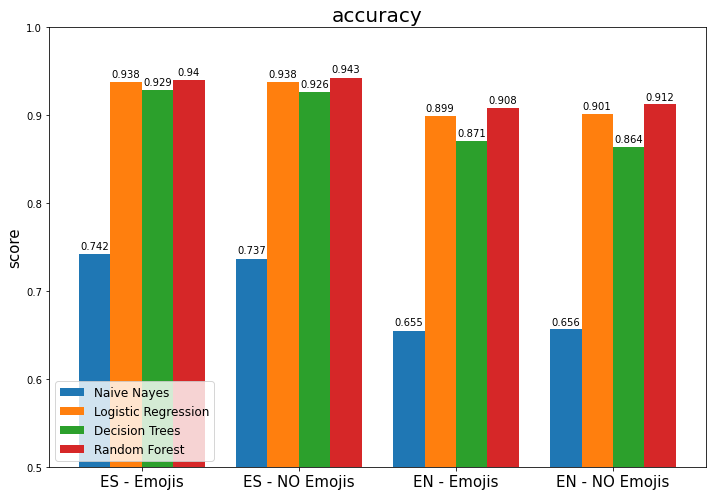

<Figure size 432x288 with 0 Axes>

In [32]:
plot_metric('accuracy')
plt.savefig('./results/mourning_tweets_accuracy.png')

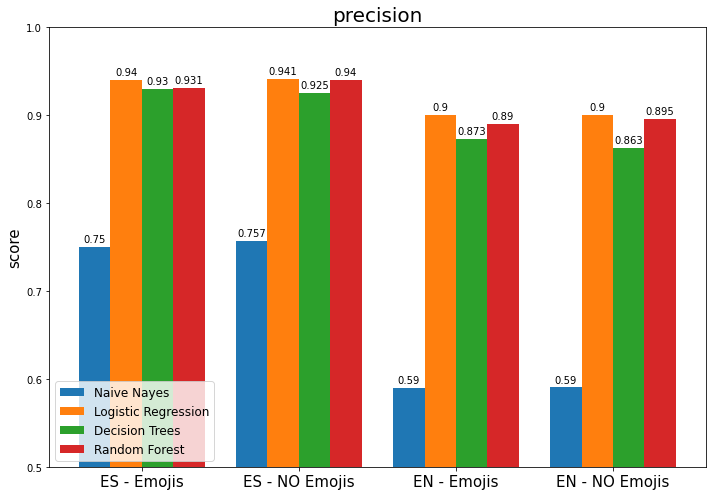

<Figure size 432x288 with 0 Axes>

In [33]:
plot_metric('precision')
plt.savefig('./results/mourning_tweets_precision.png')

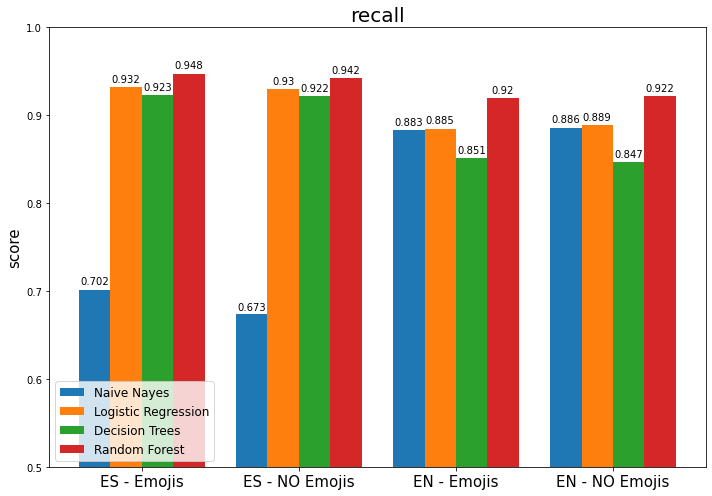

<Figure size 432x288 with 0 Axes>

In [34]:
plot_metric('recall')
plt.savefig('./results/mourning_tweets_recall.png')

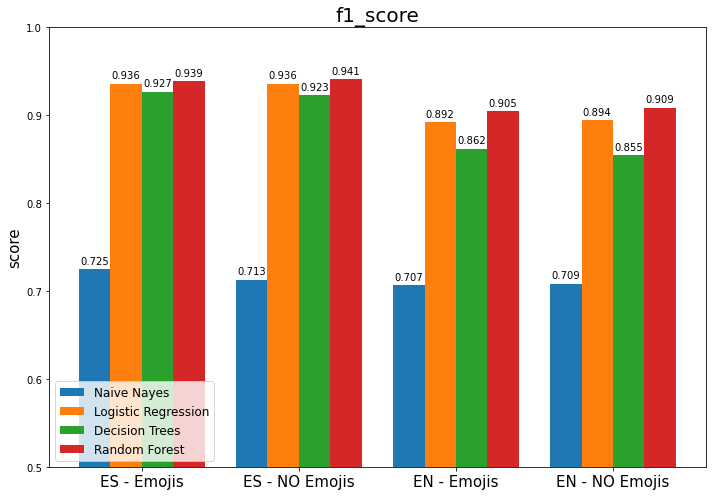

<Figure size 432x288 with 0 Axes>

In [35]:
plot_metric('f1_score')
plt.savefig('./results/mourning_tweets_f1_score.png')

## Feature Importance

### LR Parameters

In [36]:
# Add LR Parameters to ES lexicon Data Frame
es_lexicons['LR Coef'] = LR_Clf_es.coef_[0]

# Add LR Parameters to ES lexicon Data Frame
en_lexicons['LR Coef'] = LR_Clf_en.coef_[0]

In [37]:
# Sort by LR Parameter
es_lexicons.sort_values(by='LR Coef', ascending=False).head(15)

,Term,Id,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),LR Coef
252,pesar,252,0.219924,0.001055,0.995224,0.004776,8.175027
370,pena,370,0.180034,0.005910,0.968218,0.031782,6.220349
4511,condolences,4511,0.058041,0.000211,0.996377,0.003623,6.143187
2099,peña,2099,0.029126,0.000211,0.992806,0.007194,6.012844
2,condolencias,2,0.265724,0.004432,0.983594,0.016406,5.670694
434,dolor,434,0.131068,0.005488,0.959815,0.040185,5.588406
65,qepd,65,0.264035,0.010553,0.961568,0.038432,5.355301
552,luto,552,0.105952,0.075981,0.582367,0.417633,4.321091
405,qdep,405,0.010553,0.000000,1.000000,0.000000,3.608054
36,pésame,36,0.081680,0.005699,0.934783,0.065217,3.597701


In [38]:
# Sort Emojis by LR Parameter
es_lexicons.loc[es_emoji_mask].sort_values(by='LR Coef', ascending=False).head(15)

,Term,Id,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),LR Coef
50,🙏,50,0.111650,0.014141,0.887584,0.112416,1.045114
98,💔,98,0.017729,0.004854,0.785047,0.214953,1.036121
210,🕊,210,0.007809,0.000211,0.973684,0.026316,0.856794
3102,💖,3102,0.001688,0.000844,0.666667,0.333333,0.780512
1803,😟,1803,0.001055,0.000422,0.714286,0.285714,0.728737
3851,😉,3851,0.001477,0.002744,0.350000,0.650000,0.703206
130,🏽,130,0.008020,0.005910,0.575758,0.424242,0.609606
1443,▶,1443,0.002533,0.001688,0.600000,0.400000,0.592255
388,💐,388,0.003588,0.000211,0.944444,0.055556,0.553958
1763,😩,1763,0.001688,0.002955,0.363636,0.636364,0.530760


In [39]:
# Sort by LR Parameter
en_lexicons.sort_values(by='LR Coef', ascending=False).head(15)

,Term,Id,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),LR Coef
763,sorry,763,0.157606,0.002623,0.983631,0.016369,4.798363
10,rip,10,0.428946,0.060324,0.876706,0.123294,4.517498
41,condolences,41,0.189557,0.016929,0.918014,0.081986,4.093844
1500,grieving,1500,0.027897,0.001907,0.936000,0.064000,3.611101
194,heartbreaking,194,0.034096,0.003100,0.916667,0.083333,3.436517
1051,alone,1051,0.012876,0.003338,0.794118,0.205882,2.905876
798,tributes,798,0.010968,0.000477,0.958333,0.041667,2.584633
82,rest,82,0.191226,0.017883,0.914481,0.085519,2.356932
582,ripcoronawarriorbadruddin,582,0.010253,0.000715,0.934783,0.065217,2.236972
1786,restinpeace,1786,0.004053,0.000238,0.944444,0.055556,2.113009


In [40]:
# Sort Emojis by LR Parameter
en_lexicons.loc[en_emoji_mask].sort_values(by='LR Coef', ascending=False).head(15)

,Term,Id,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),LR Coef
103,😢,103,0.040534,0.003338,0.923913,0.076087,1.141360
1898,💗,1898,0.003338,0.000238,0.933333,0.066667,1.095251
192,🙏,192,0.188603,0.035765,0.840595,0.159405,1.002427
985,🕊,985,0.010968,0.000715,0.938776,0.061224,0.905269
422,😪,422,0.006199,0.000954,0.866667,0.133333,0.900443
751,😔,751,0.024082,0.002384,0.909910,0.090090,0.858096
83,💔,83,0.069146,0.004769,0.935484,0.064516,0.798324
578,😭,578,0.038627,0.011206,0.775120,0.224880,0.740716
577,💕,577,0.005246,0.002384,0.687500,0.312500,0.707609
1131,😡,1131,0.006676,0.000715,0.903226,0.096774,0.706983


### Mean Decrease Impurity

In [41]:
# Add RF Parameters to ES lexicon Data Frame
es_lexicons['RF Coef'] = RF_Clf_es.feature_importances_

# Add RF Parameters to ES lexicon Data Frame
en_lexicons['RF Coef'] = RF_Clf_en.feature_importances_

In [42]:
# Sort by RF Parameter
es_lexicons.sort_values(by='RF Coef', ascending=False).head(15)

,Term,Id,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),LR Coef,RF Coef
252,pesar,252,0.219924,0.001055,0.995224,0.004776,8.175027,0.094625
65,qepd,65,0.264035,0.010553,0.961568,0.038432,5.355301,0.076489
370,pena,370,0.180034,0.005910,0.968218,0.031782,6.220349,0.063508
2,condolencias,2,0.265724,0.004432,0.983594,0.016406,5.670694,0.053401
434,dolor,434,0.131068,0.005488,0.959815,0.040185,5.588406,0.035788
4511,condolences,4511,0.058041,0.000211,0.996377,0.003623,6.143187,0.034384
325,dep,325,0.098143,0.017307,0.850091,0.149909,2.940556,0.017831
27,familia,27,0.175813,0.020473,0.895699,0.104301,0.654124,0.016327
552,luto,552,0.105952,0.075981,0.582367,0.417633,4.321091,0.015456
36,pésame,36,0.081680,0.005699,0.934783,0.065217,3.597701,0.014046


In [43]:
# Sort Emojis by RF Parameter
es_lexicons.loc[es_emoji_mask].sort_values(by='RF Coef', ascending=False).head(15)

,Term,Id,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),LR Coef,RF Coef
50,🙏,50,0.111650,0.014141,0.887584,0.112416,1.045114,0.009585
99,😔,99,0.032292,0.009709,0.768844,0.231156,0.144022,0.002235
3298,😂,3298,0.007598,0.043056,0.150000,0.850000,-0.828608,0.001282
98,💔,98,0.017729,0.004854,0.785047,0.214953,1.036121,0.001259
1085,😢,1085,0.023217,0.005910,0.797101,0.202899,0.425594,0.001115
1079,😥,1079,0.011608,0.002322,0.833333,0.166667,0.403658,0.000966
67,😭,67,0.023850,0.014352,0.624309,0.375691,0.160469,0.000721
1325,😞,1325,0.007387,0.001688,0.813953,0.186047,-0.837244,0.000562
210,🕊,210,0.007809,0.000211,0.973684,0.026316,0.856794,0.000559
300,🥺,300,0.014563,0.009287,0.610619,0.389381,0.446095,0.000527


In [44]:
# Sort by RF Parameter
en_lexicons.sort_values(by='RF Coef', ascending=False).head(15)

,Term,Id,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),LR Coef,RF Coef
10,rip,10,0.428946,0.060324,0.876706,0.123294,4.517498,0.120024
763,sorry,763,0.157606,0.002623,0.983631,0.016369,4.798363,0.046132
41,condolences,41,0.189557,0.016929,0.918014,0.081986,4.093844,0.034969
82,rest,82,0.191226,0.017883,0.914481,0.085519,2.356932,0.034011
265,loss,265,0.141154,0.007153,0.951768,0.048232,1.863182,0.026177
62,lost,62,0.153553,0.017883,0.895688,0.104312,1.931425,0.017363
142,family,142,0.178827,0.029089,0.860092,0.139908,0.792774,0.015630
81,peace,81,0.200763,0.071531,0.737303,0.262697,1.977187,0.014728
194,heartbreaking,194,0.034096,0.003100,0.916667,0.083333,3.436517,0.012597
192,🙏,192,0.188603,0.035765,0.840595,0.159405,1.002427,0.011552


In [45]:
# Sort Emojis by RF Parameter
es_lexicons.loc[es_emoji_mask].sort_values(by='RF Coef', ascending=False).head(15)

,Term,Id,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),LR Coef,RF Coef
50,🙏,50,0.111650,0.014141,0.887584,0.112416,1.045114,0.009585
99,😔,99,0.032292,0.009709,0.768844,0.231156,0.144022,0.002235
3298,😂,3298,0.007598,0.043056,0.150000,0.850000,-0.828608,0.001282
98,💔,98,0.017729,0.004854,0.785047,0.214953,1.036121,0.001259
1085,😢,1085,0.023217,0.005910,0.797101,0.202899,0.425594,0.001115
1079,😥,1079,0.011608,0.002322,0.833333,0.166667,0.403658,0.000966
67,😭,67,0.023850,0.014352,0.624309,0.375691,0.160469,0.000721
1325,😞,1325,0.007387,0.001688,0.813953,0.186047,-0.837244,0.000562
210,🕊,210,0.007809,0.000211,0.973684,0.026316,0.856794,0.000559
300,🥺,300,0.014563,0.009287,0.610619,0.389381,0.446095,0.000527
